In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#The following allow direct FEniCS code into python scripts.

def ln(input):
    return np.log(input)

def Constant(constant):
    return constant

#Import the specifications
from jupyterinputs import *

epsmet = 0

In [2]:
def Ws(epsmet):
    return (1-epsTotal(epsmet))*ads_rho_bulk*ads_ws 
Ws(epsmet)

0.1167179022472055

In [3]:
p_atm = 101325 # Pa
t = 298.15 # K
# r = [kg adsorbate / adsorbant m3] 
relativeHumidity_list = np.linspace(.01,.5,100) #Relative Humidity [pH20/psat]
#p_sat = Psat_YAWS_1999(t)/((Rg/vap_mg)*t) #This analysis was not finished 
p_list = relativeHumidity_list*Psat_YAWS_1999(t)#  Partial pressure of water

#Part2 = ln(vap_pcr/p*pow(t/vap_tcr,2))
#Creates a list of partial pressures at constant temperature and pressure

In [4]:
#Option 3 Osawa aka Dubinin
def rhoads_T(t): #[kg/m3]
    Tb = Constant(373.2)
    alphae = Constant(7.03e-4)   # Thermal Expansion of Liquefied Gases
    return vap_rhoads/(exp(alphae*(t - Tb)))#Sahoo, uses Gas Density at Boiling, and Thermal Expansion of

def Ws(epsmet): #Volume of micropore volume per adsorbent bed volume
    #ads_ws # [m3/kg]
    #ads_rho_bulk [kg/m3]    
    return (1-epsTotal(epsmet))*ads_rho_bulk*ads_ws

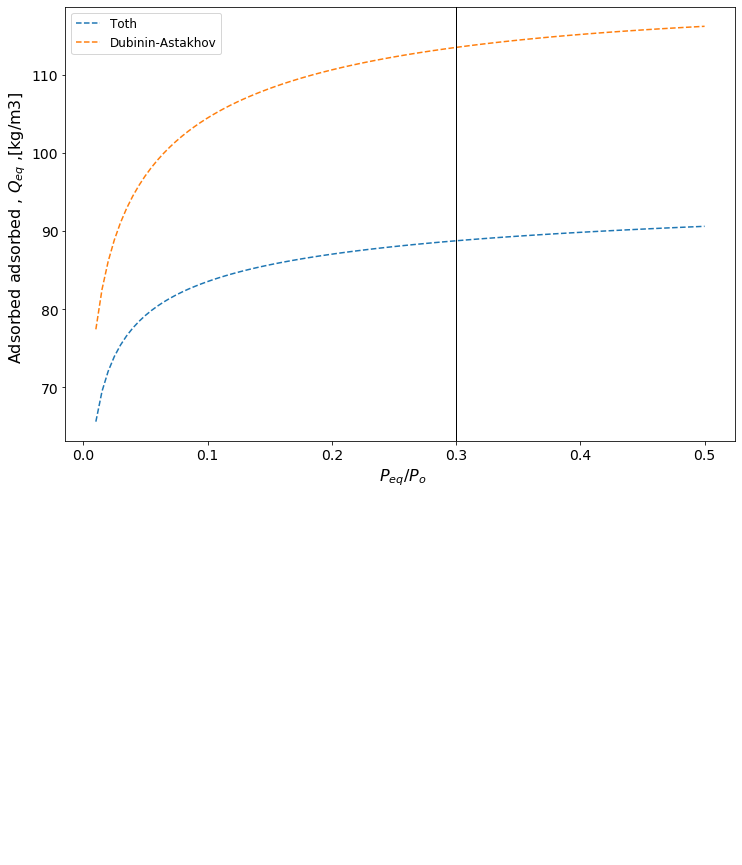

In [8]:
Iso_Dubinin_Astakhov_list = []
Iso_Toth_list = []
Iso_Dubinin_Radushkevich_list = []


#Option 1
def Dubinin_Astakhov(p,t): #[kg/m3] Equilibrium Density of Adsorbed Gas
    return rhoads_T(t)*Ws(epsmet)*exp(-pow((Rg * t * ln(Psat_YAWS_1999(t)/(p))/(E0_beta)),ads_ns))

#Option 2
def Toth(p,t): #[kg / kg] with vap_mg , [mol/kg] without it
    toth_a0 = Constant(3.634e-9) #[mol/(kg.Pa)] 
    toth_b0 = Constant(2.408e-10) #[1/Pa]
    toth_c0 = Constant(-4.199) #[K]
    toth_g0 = Constant(3.974e-1) #[-]
    toth_E0 = Constant(6.852e3) #[K]
    #vap_mg = Constant(.01801528) # Converts mol to kg
    def toth_a(t): #related to b and the saturation capacity
        return (toth_a0*exp(toth_E0/t))  
    def toth_b(t): #is equilibrium constant
        return (toth_b0*exp(toth_E0/t))
    def toth_g(t): #characterizes the surface heterogenneity of the adsorbent
        return toth_g0+toth_g0/t
    toth = vap_mg*((toth_a(t)*p) / ( pow(1+pow((toth_b(t)*p),toth_g(t)),(1/toth_g(t))))) #[mol / kg] toth *vap_mg[kg/mol] = [kg/kg]
    #ceq = (1-epsTotal(epsmet))*ads_rho_bulk*toth #  Toth [mol/kg]*ads_rho_crystal[kg/m3/] = Ceq[mol/m3]
    #return ads_rho_crystal*toth #[kg/m3] with porosity calculations
    return (1-epsTotal(epsmet))*ads_rho_crystal*toth #Toth[kg/kg], Ads_rho_bulk [kg/m3]
    #return rhoads_T(t)*(1-epsTotal(epsmet))*ads_rho_bulk*ads_ws*toth

#Option 3
def Dubinin_Radushkevich(p,t): #[kg/m3] Vasiliev built from Narayanan (2017) 
    W0 = 1#Maximum Microporous Specific Volume [m3/kg]
    va = 1#Specific Volume of Adsorbed Medium [m3/kg]
    DR_beta = Constant(.2)
    DR_Ea = Constant(91400) #[J/mol]
    E_DR = DR_beta * DR_Ea # [J/mol] Characteristic Energy of Adsorption #Vasiliev defines as Activation Energy [J/kg]
    #E_DR = E0_beta
    Ru = Rg #/vap_mg# [J / (Kg K)]
    #Polyani = vap_pcr/p * pow(t/vap_tcr,2)
    Polyani = Psat_YAWS_1999(t)/p
    DR = exp(-pow((Ru*t/E_DR  * ln(Polyani )),2)) #
    return  rhoads_T(t)*Ws(epsmet)*DR   # W0/va Vasiliev included these but in Amigo they are p_adg * Ws 

for p in p_list:
    #print(p)
    Iso_Toth_list.append(Toth(p,t))
    Iso_Dubinin_Astakhov_list.append(Dubinin_Astakhov(p,t))
    Iso_Dubinin_Radushkevich_list.append(Dubinin_Radushkevich(p,t))
    
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('')
ax.plot(relativeHumidity_list,Iso_Toth_list, label="Toth", linestyle='dashed')
ax.plot(relativeHumidity_list,Iso_Dubinin_Astakhov_list, label="Dubinin-Astakhov", linestyle='dashed')
#ax.plot(relativeHumidity_list,Iso_Dubinin_Radushkevich_list, label = 'Dubinin-Radushkevich', linestyle='dashed')
ax.set_xlabel(r' $P_{eq} / P_o$',fontsize=16)
ax.set_ylabel('Adsorbed adsorbed , $Q_{eq}$ ,[kg/m3]  ',fontsize=16)
plt.axvline(.3, linewidth=1, color="black")
plt.annotate('Capillary Condensation', xy =(0.302,10))
plt.xticks(fontsize=14 )
plt.yticks(fontsize=14 )
ax.legend(fontsize=12)  
fig.savefig('Isotherm.png')
plt.show()

#pd.DataFrame({'Pw/Po' : relativeHumidity_list, 'Toth ': Iso_Toth_list, 'Ambrozek' : Iso_Ambrozek_list,'Dubinin-Astakhov': Iso_DA_list, 'Dubinin - Radushkevich' : Iso_Dubinin_Radushkevich_list}) 
#ax.plot(relativeHumidity_list,Iso_Ambrozek_list, label="Dubinin-Astakhov", linestyle='dashed')

In [ ]:
def Toth(p,t): #[kg / kg] with vap_mg , [mol/kg] without it
    toth_a0 = Constant(3.634e-9) #[mol/(kg.Pa)] 
    toth_b0 = Constant(2.408e-10) #[1/Pa]
    toth_c0 = Constant(-4.199) #[K]
    toth_g0 = Constant(3.974e-1) #[-]
    toth_E0 = Constant(6.852e3) #[K]
    #vap_mg = Constant(.01801528) # Converts mol to kg
    def toth_a(t): #related to b and the saturation capacity
        return (toth_a0*exp(toth_E0/t))  
    def toth_b(t): #is equilibrium constant
        return (toth_b0*exp(toth_E0/t))
    def toth_g(t): #characterizes the surface heterogenneity of the adsorbent
        return toth_g0+toth_g0/t
    toth = ((toth_a(t)*p) / ( pow(1+pow((toth_b(t)*p),toth_g(t)),(1/toth_g(t)))))*vap_mg #[mol / kg] toth *vap_mg[kg/mol] = [kg/kg]
    #ceq = (1-epsTotal(epsmet))*ads_rho_bulk*toth #  Toth [mol/kg]*ads_rho_crystal[kg/m3/] = Ceq[mol/m3]
    #return ads_rho_crystal*toth #[kg/m3] with porosity calculations
    return toth#*(1-epsTotal(epsmet))*ads_rho_crystal #Toth[kg/kg], Ads_rho_bulk [kg/m3]
    #return rhoads_T(t)*(1-epsTotal(epsmet))*ads_rho_bulk*ads_ws*toth



In [ ]:
def Toth_FA(p,t):#[kg/m3]
    Q = GH_DelH(p,t)
    #Q = Constant(7.787e4)
    toth_b = Constant(2.408e-10)*exp(Q/(Rg*t))#[1/Pa]
    toth_t = Constant(3.974e-1) #[-]
    return rhoads_T(t)*Ws(epsmet)*(toth_b*p/(pow(1+pow(toth_b*p,toth_t),1/toth_t)))
    #return Constant(.018)*Constant(16.3)*( (9.04e5)*p / pow(1+pow(9.04e5*p,.257),1/.257) )
    
def VapAdsCap(p,t):  #W0, Maximum Uptake defined by pore space available for adsorption 
    return Qeq(p,t,epsmet)/((1-epsTotal(epsmet))*ads_rho_bulk)

def GH_DelH(p,t): # [J/mol] Gibbs-Helmholtz equation (GH) Dubinin (1967) Found in Cortes (2010)
    P_o = Constant(Psat_YAWS_1999(t)) #[Pa] Saturation Pressure
    P_w = p #[Pa] Partial Pressure
    #alphae =Constant(2.07e-4)
    #alphae = alphae_liq(t,to,r,ro)
    alphae = Constant(7.03e-5) # # Thermal Expansion of Liquefied Gases
    n = Constant(1.6) #Cortes, 2010 Backfitted from linear regression, this is the exponential in the DA 
    D =  Rg/E0_beta# Cortes (2010) names this the coefficient of Affinity and backfits. 
    Qvap = Constant(4.54e4) #J/mol Narayanan
    return Qvap + Rg*t*ln(P_o/P_w) + alphae*Rg*t/(n*D)*pow((t*ln(P_o/P_w)),(1-n))
    #return ()*18.01528 #/0.055508435061792# Was [J/g]  to go to [J/mol]   0.055508435061792 goes from gram to mole
    

def Iso_Ambrozek(p,t):#Density [kg/m3] 
    Ambrozek_n = Constant(1.806)
    Ambrozek_Beta_EO = Constant (18445) #[J/mol]
    Ambrozek_V_O = Constant(2.114e-4) #[m3/kg] Limiting Adsorption Volumes, removed forr use of Ws
    A_Ambrozek = Rg*t*ln(Psat_YAWS_1999(t)/p) #[J/mol]
    Ambrozek_V = (exp(-pow((A_Ambrozek/(Ambrozek_Beta_EO)),Ambrozek_n)))  #[-]
    return rhoads_T(t)*Ws(epsmet)*Ambrozek_V

        #elif AdsorptionDensityEquilibrium ==3: #Toth from Ferreira
            #return Constant(.018)*Constant(16.3)*( (9.04e5)*p / pow(1+pow(9.04e5*p,.257),1/.257) )
        #elif AdsorptionDensityEquilibrium ==4: #DA from Ferreira 
            #return Constant(.018)*Constant(13.0)*exp(-1*pow((A2(p,t)/Constant(22800)),1.2))
        #elif AdsorptionDensityEquilibrium ==5: #Dubinin-Astakhov Sahoo
        #    return vap_mg*(ads_rho_crystal*toth_a(p,t)*p) / ( pow(1+pow((toth_b(p,t)*p),toth_g(t)),(1/toth_g(t))))
        #elif AdsorptionDensityEquilibrium ==6: #Modified BET
        #    RpBET = RelativePressure(p,t,r)
        #    return rhoads_T(t) * Ws(epsmet) *pow((CBET*RpBET),alphaBET) / ((1-RpBET+pow((CBET*RpBET),alphaBET)))